## This next assignment is a quick basic tutorial of one of the possible applications of the RNN - NLP with name classification and generation.


### Task 1. Go over to https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html . 
### Go through the tutorial, understand the code and implement it here.

In [1]:
#Begin your code here, feel free to use more cells for organizing your code.

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print(len(all_categories), all_categories)
# print(category_lines)

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
Slusarski
18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


In [3]:
# Turning Names into Tensors
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [4]:
# Creating the Network
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
# rnn = RNN(n_letters, n_hidden, n_categories)
rnn = RNN(len(all_letters), n_hidden, len(all_categories))

In [5]:
# run a step of this network
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(output)

tensor([[-2.9104, -2.9525, -2.9291, -2.9028, -2.8150, -2.8491, -2.9050, -2.8751,
         -2.8775, -2.8621, -2.8969, -2.9434, -2.8480, -2.9228, -2.8433, -2.8906,
         -2.9031, -2.9117]], grad_fn=<LogSoftmaxBackward>)


In [6]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9104, -2.9525, -2.9291, -2.9028, -2.8150, -2.8491, -2.9050, -2.8751,
         -2.8775, -2.8621, -2.8969, -2.9434, -2.8480, -2.9228, -2.8433, -2.8906,
         -2.9031, -2.9117]], grad_fn=<LogSoftmaxBackward>)


In [7]:
# Preparing for Training
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('English', 4)


In [8]:
# a quick way to get a training example (a name and its language)
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Korean / line = San
category = French / line = Deschamps
category = Korean / line = Gwang 
category = French / line = Perrot
category = Irish / line = Casey
category = French / line = Bureau
category = Portuguese / line = Santos
category = Spanish / line = Orellana
category = Arabic / line = Sarraf
category = Spanish / line = Abreu


In [9]:
# Training the Network
criterion = nn.NLLLoss()

learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [10]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


In [11]:
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d \t %d%% \t (%s) \t %.4f %20s / %-20s \t %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 	 5% 	 (0m 5s) 	 2.9616                Costa / Korean               	 ✗ (Spanish)
10000 	 10% 	 (0m 11s) 	 2.5724             Sandoval / Irish                	 ✗ (Spanish)
15000 	 15% 	 (0m 16s) 	 2.2575                Senft / Spanish              	 ✗ (German)
20000 	 20% 	 (0m 22s) 	 2.6943                Close / French               	 ✗ (Greek)
25000 	 25% 	 (0m 28s) 	 1.7562             Kruessel / Russian              	 ✗ (Czech)
30000 	 30% 	 (0m 33s) 	 3.3173                 Mata / Japanese             	 ✗ (Portuguese)
35000 	 35% 	 (0m 39s) 	 0.3791                Danas / Greek                	 ✓
40000 	 40% 	 (0m 44s) 	 1.3406             Santiago / Italian              	 ✗ (Portuguese)
45000 	 45% 	 (0m 50s) 	 0.7915              Hodowal / Czech                	 ✓
50000 	 50% 	 (0m 55s) 	 0.7225             Cervenka / Czech                	 ✓
55000 	 55% 	 (1m 1s) 	 4.7030              Francis / Portuguese           	 ✗ (English)
60000 	 60% 	 (1m 7s) 	 0.2188             

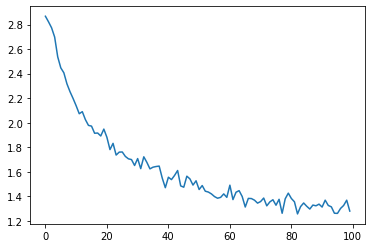

In [12]:
# Plotting the historical loss from all_losses shows the network learning:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

### Task 2. Now use the dataset of Kazakh names supplied with this assignment, and include it with the original 18 datasets. Now, you should have 19 name datasets. Rerun the code up to the confusion matrix part (excluding it).

In [13]:
Completed = True #Set it to true once done. 

In [14]:
filename = './Kazakh.txt'
category = os.path.splitext(os.path.basename(filename))[0]
all_categories.append(category)
lines = readLines(filename)
category_lines[category] = lines
print(len(all_categories), all_categories)

19 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese', 'Kazakh']


In [15]:
rnn = RNN(len(all_letters), n_hidden, len(all_categories))

In [16]:
# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
#         print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
        print('%d \t %d%% \t (%s) \t %.4f %20s / %-20s \t %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))


    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 	 5% 	 (0m 5s) 	 2.4979           Regenbogen / Dutch                	 ✗ (German)
10000 	 10% 	 (0m 11s) 	 1.3584                Chung / Chinese              	 ✗ (Vietnamese)
15000 	 15% 	 (0m 16s) 	 2.5188               Fabron / Scottish             	 ✗ (French)
20000 	 20% 	 (0m 22s) 	 2.8351               Tsogas / Arabic               	 ✗ (Greek)
25000 	 25% 	 (0m 27s) 	 2.1279              D'cruze / French               	 ✗ (Portuguese)
30000 	 30% 	 (0m 33s) 	 2.6912               Cabral / Kazakh               	 ✗ (Portuguese)
35000 	 35% 	 (0m 39s) 	 2.5095                 Tron / Korean               	 ✗ (Vietnamese)
40000 	 40% 	 (0m 44s) 	 0.6317              Szwedko / Polish               	 ✓
45000 	 45% 	 (0m 50s) 	 1.4394             Christie / Scottish             	 ✓
50000 	 50% 	 (0m 55s) 	 0.8731             Mukaseev / Russian              	 ✓
55000 	 55% 	 (1m 1s) 	 0.0493             Agostini / Italian              	 ✓
60000 	 60% 	 (1m 6s) 	 0.5080             Cha

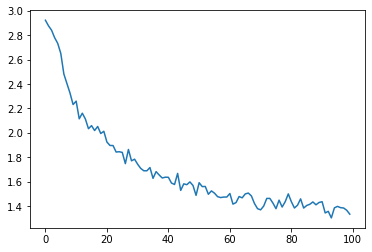

In [17]:
plt.figure()
plt.plot(all_losses)

### Task 3. Plot the confusion matrix of the names, and write 5-6 sentences on the notable things that you observe. Why do we use the confusion matrix? 

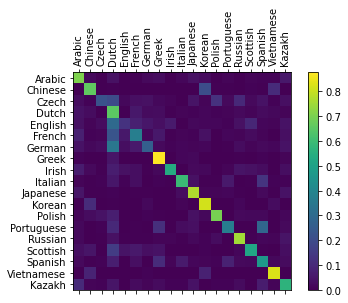

In [18]:
#Your code here
# Keep track of correct guesses in a confusion matrix
n_categories = len(all_categories)
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

On the presented confusion matrix, we can observe that, in general, names are determined in accordance with their nationality. A clear line is drawn along the main diagonal. However, some points can be marked. For example, Vietnamese and Greek, which have more than 80% accuracy, and English, which have less than 20% accuracy. At the same time, we can observe that English names are often confused with Irish and Scottish names. Kazakh names are most likely to be confused with Arabic and Russian names.

### Task 4. Run the predictions on the following

In [19]:
# Running on User Input
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.53) Russian
(-1.34) Czech
(-3.04) Polish

> Jackson
(-1.36) English
(-1.54) Russian
(-1.56) Scottish

> Satoshi
(-0.82) Japanese
(-1.11) Italian
(-3.21) Polish


In [20]:
predict('Yoda')
predict('Windu')
predict('Kenobi')


> Yoda
(-0.87) Korean
(-1.37) Japanese
(-2.58) Spanish

> Windu
(-1.84) German
(-1.86) Irish
(-1.90) Japanese

> Kenobi
(-0.83) Japanese
(-1.44) Arabic
(-2.06) Dutch


In [21]:
predict('Okabe')
predict('Christina')
predict('Kurisu')
predict('Ruka')
predict('Steins')
predict('Leskinen')
predict('Maho')


> Okabe
(-0.26) Japanese
(-3.13) Kazakh
(-3.17) Dutch

> Christina
(-1.44) Japanese
(-1.81) Kazakh
(-2.01) Italian

> Kurisu
(-1.09) Japanese
(-1.66) German
(-2.15) Dutch

> Ruka
(-1.16) Czech
(-1.27) Korean
(-2.03) Polish

> Steins
(-0.78) Dutch
(-2.38) Portuguese
(-2.54) Greek

> Leskinen
(-0.31) Dutch
(-2.45) German
(-2.52) Russian

> Maho
(-1.04) Chinese
(-1.69) Japanese
(-1.95) Portuguese


In [22]:
predict('Dmitriy')
predict('Vlad')
predict('Kaisar')
predict('Caesar')
predict('Andrey')
predict('Sabir')
predict('Abay')
predict('Atabay')
predict('Rustem') #essential, don't forget!


> Dmitriy
(-0.62) Russian
(-1.76) Scottish
(-2.89) Irish

> Vlad
(-1.48) English
(-1.99) Scottish
(-2.26) French

> Kaisar
(-0.17) Arabic
(-2.23) Kazakh
(-4.28) Czech

> Caesar
(-1.59) French
(-2.00) Czech
(-2.06) Portuguese

> Andrey
(-1.48) Dutch
(-1.69) English
(-1.82) Spanish

> Sabir
(-0.82) Kazakh
(-1.20) Arabic
(-2.62) German

> Abay
(-0.27) Kazakh
(-2.61) Arabic
(-3.00) Scottish

> Atabay
(-0.54) Kazakh
(-0.98) Arabic
(-4.34) Greek

> Rustem
(-0.68) Dutch
(-1.61) Spanish
(-2.63) English


### Task 5. Repeat tasks 1 & 4 but with https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html.
#### No need to delete the Kazakh Names dataset, keep it (19 datasets total)

In [23]:
#Start your code here
print(len(all_categories), all_categories)

19 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese', 'Kazakh']


In [24]:
# Creating the Network
import torch
import torch.nn as nn

n_categories = len(all_categories)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [25]:
# helper functions to get random pairs of (category, line)

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [26]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [27]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [28]:
# Training the Network
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [29]:
# Training

rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s \t (%6d %3d%%) \t %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 13s 	 (  5000   5%) 	 2.9294
0m 26s 	 ( 10000  10%) 	 2.3720
0m 40s 	 ( 15000  15%) 	 2.2335
0m 54s 	 ( 20000  20%) 	 3.1519
1m 8s 	 ( 25000  25%) 	 2.3510
1m 22s 	 ( 30000  30%) 	 3.3144
1m 36s 	 ( 35000  35%) 	 2.5233
1m 49s 	 ( 40000  40%) 	 2.2980
2m 2s 	 ( 45000  45%) 	 2.7704
2m 16s 	 ( 50000  50%) 	 1.2292
2m 29s 	 ( 55000  55%) 	 2.9306
2m 43s 	 ( 60000  60%) 	 1.9913
2m 57s 	 ( 65000  65%) 	 1.6508
3m 10s 	 ( 70000  70%) 	 2.4829
3m 24s 	 ( 75000  75%) 	 1.3906
3m 38s 	 ( 80000  80%) 	 2.5652
3m 52s 	 ( 85000  85%) 	 2.6583
4m 5s 	 ( 90000  90%) 	 2.4900
4m 18s 	 ( 95000  95%) 	 1.7073
4m 31s 	 (100000 100%) 	 1.5871


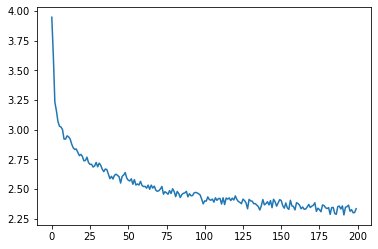

In [30]:
# Plotting the Losses
plt.figure()
plt.plot(all_losses)

In [31]:
# Sampling the Network
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Rovek
Uarinov
Santov
Garen
Eren
Roure
Sare
Pare
Allan
Chan
Han
Iui


In [32]:
samples('Russian', 'ASDFG')

Allinov
Shinoveki
Doveri
Farinov
Garikov


In [33]:
samples('German', 'ASDFG')

Arter
Serter
Derren
Ferren
Gerre


In [34]:
samples('Spanish', 'ASDFG')

Allan
Sare
Daner
Fandera
Garese


In [35]:
samples('Kazakh', 'ASDFG')

Alas
Salak
Danima
Fariana
Garim
